# Radon-CDT Demo

This notebook accompanies the following tutorial:

https://github.com/skolouri/Radon-Cumulative-Distribution-Transform


In [1]:
import sys
sys.path.append('./transportBasedTransforms/')
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import radon,iradon
import transportBasedTransforms.radonCDT as RCDT
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.ndimage import filters
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
%matplotlib inline

## Nonlinearty experiment

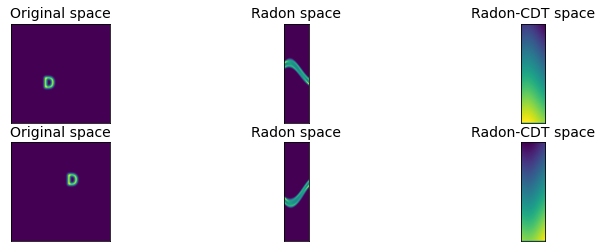

In [2]:
#Get a Radon-CDT object
theta=np.arange(180)
rcdt=RCDT.RadonCDT(theta)
# Load images and calculate their Radon-CDT
I=[]
rI=[]
Ihat=[]
for i in range(2):
    I.append(rgb2gray(imread('./Data/I%d.bmp'%(i))))
    rI.append(radon(I[i],theta,circle=False))
    Ihat.append(rcdt.transform(I[i]))
data=[I,rI,Ihat]
fig,ax=plt.subplots(2,3,figsize=(12,4))
title=['Original space','Radon space','Radon-CDT space']
for i in range(2):
    for j in range(3):
        ax[i,j].imshow(data[j][i])
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])    
        ax[i,j].set_title(title[j],fontsize=14)

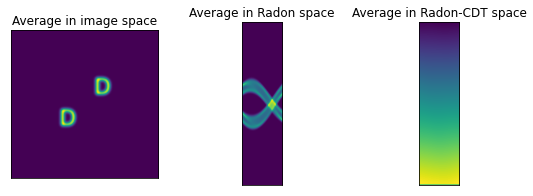

In [3]:
fig, ax=plt.subplots(1,3,figsize=(9,3))
title=['Average in image space','Average in Radon space', 'Average in Radon-CDT space']
avg=[]
for i in range(3):
    avg.append(0.5*(data[i][0]+data[i][1]))    
    ax[i].imshow(avg[i])
    ax[i].set_title(title[i],fontsize=12)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

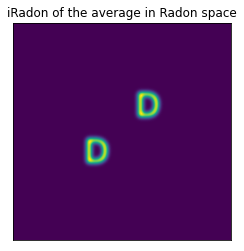

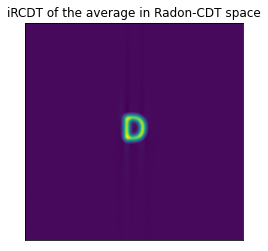

In [4]:
plt.imshow(iradon(avg[1],circle=False))
plt.xticks([])
plt.yticks([])
plt.title('iRadon of the average in Radon space')
plt.show()
plt.imshow(rcdt.itransform(avg[2]))
plt.xticks([])
plt.yticks([])
plt.title('iRCDT of the average in Radon-CDT space')
plt.show()

## Linear Separability

In [5]:
#Generate 3 classes of k-modal two-dimensional Gaussians
N=1000 # Number of datapoints per class
sigma=3# Standard deviation of each Gaussian
#Initialize
I=np.zeros((3,N,128,128)) 
K,L=rcdt.transform(I[0,0,:,:]).shape
Ihat=np.zeros((3,N,K,L))
#Generate dataset
for c in range(3):
    for i in range(N):
        for _ in range(c+1):
            x,y=np.random.uniform(30,98,(2,)).astype('int')        
            I[c,i,x,y]=1
        I[c,i,:,:]=I[c,i,:,:]/I[c,i,:,:].sum()
        I[c,i,:,:]=filters.gaussian_filter(I[c,i,:,:],sigma=sigma)    
        Ihat[c,i,:,:]=rcdt.transform(I[c,i,:,:])    

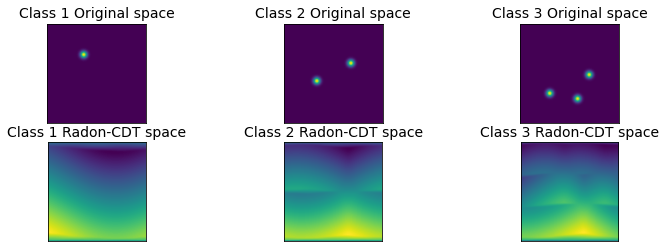

In [6]:
fig,ax=plt.subplots(2,3,figsize=(12,4))
title=['Class 1','Class 2','Class 3']
for c in range(3):
    ind=np.random.randint(low=0,high=N) 
    ax[0,c].imshow(I[c,ind,:,:])
    ax[0,c].set_xticks([])
    ax[0,c].set_yticks([])
    ax[0,c].set_title(title[c]+' Original space',fontsize=14)
    ax[1,c].imshow(Ihat[c,ind,:,:])
    ax[1,c].set_xticks([])
    ax[1,c].set_yticks([])
    ax[1,c].set_title(title[c]+' Radon-CDT space',fontsize=14)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


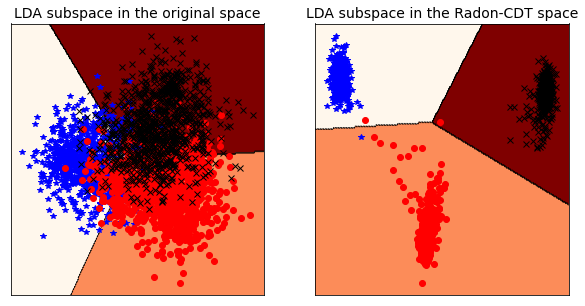

In [7]:
X=np.reshape(I,(3*N,128*128))
Xhat=np.reshape(Ihat,(3*N,K*L))
label=np.concatenate((np.concatenate((-np.ones(N),np.zeros(N)),0),np.ones(N)),0)
lda=LDA(n_components=2)
n=N
# Apply LDA  in Signal Space
Xlda=lda.fit_transform(X,label)
svm=LinearSVC()
svm.fit(Xlda,label)
# Apply LDA in transform space 
Xhatlda=lda.fit_transform(Xhat,label)
svmhat=LinearSVC()
svmhat.fit(Xhatlda,label)
# Show classification boundaries in both Spaces
svmClassifier=[svm,svmhat]
Xdata=[Xlda,Xhatlda]
title=['LDA subspace in the original space','LDA subspace in the Radon-CDT space']
fig,ax=plt.subplots(1,2,figsize=(10,5))
for i in range(2):
    ax[i].plot(Xdata[i][:n,0],Xdata[i][:n,1],'b*')
    ax[i].plot(Xdata[i][n:2*n,0],Xdata[i][n:2*n,1],'ro')
    ax[i].plot(Xdata[i][2*n:,0],Xdata[i][2*n:,1],'kx')

    x_min, x_max = ax[i].get_xlim()
    y_min, y_max = ax[i].get_ylim()
    nx, ny = 400, 200
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = svmClassifier[i].predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:].reshape(xx.shape)

    ax[i].pcolormesh(xx, yy, Z,cmap='OrRd')
    ax[i].contour(xx, yy, Z, linewidths=.5, colors='k')
    ax[i].set_title(title[i],fontsize=14)
    ax[i].set_xticks([])
    ax[i].set_yticks([])